Esse notebook irá fazer um baseline utilizando ml para computar a probabilidade de um nó ser ocultado baseando-se apenas na expressão da descrição. Os dados de treinamento serão criados expandindo-se apenas um nível da árvore de provas, chamando os novos nós de 1 e os originais 0. Para verificar se os nós são os mesmos, vamos utilizar as expressões apenas, já que uma vez que um nó é expandido a sua proposição original se quebra em diversas proposições que constituem sua prova.

https://www.youtube.com/watch?v=8owQBFAHw7E

https://www.youtube.com/watch?v=uF53xsT7mjc

In [1]:
import sys
sys.path.append("..")

import random

from collections import Counter, defaultdict

import json

import glob

import os

import numpy as np

#from tree_parser import file_contents, meta_math_database

#from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
#from my_utils import get_proof_steps_graph, print_proof_steps_graph
#from expanding import construct_proof, expand_proof_step_ps, expand_all_nodes_with_depth
#from expanding import PStep, construct_proof

from tqdm import tqdm

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

In [2]:
all_props = json.load(open("prop_dataset_1659467564.761641.json"))
props_dict = {p['prop']:p for p in all_props}
print(len(props_dict))

7476


In [3]:
test_props = [
    "dfss3",
    "dfss2",
    "dfss",
    "t1lucas",
    "t2lucas",
    "ssun1",
    "t4lucas",
    "t5lucas",
    "opoe",
    "omoe",
    "pwin",
    "inidm",
    "in0",
    "sstr",
    "ssequn1",
    "pwunss",
    "epee",
    "emee",
    "oddp1eveni",
    "dvdsadd2b",
    "opoeALTV",
    "omoeALTV"
]

#Ensure everything exists
for t in test_props:
    if t not in props_dict.keys():
        print(f"{t} not in database.")

opoe not in database.
omoe not in database.
epee not in database.
emee not in database.
oddp1eveni not in database.
dvdsadd2b not in database.
opoeALTV not in database.
omoeALTV not in database.


In [4]:
train_props = [p for p in props_dict.keys() if p not in test_props]

In [5]:
train_props, valid_props = train_test_split(train_props, test_size=0.2, random_state=2)
print(len(train_props), len(valid_props))

5969 1493


In [17]:
def get_prop_parameters(target_prop):
    steps_dict = {s[0]:{"prop": s[1], "statement":s[2], "prop_statement":s[3], "y":s[4]} for s in target_prop["steps"]}

    #Add neighbors refs
    for s in steps_dict.values():
        s["inputs"] = []
        s["output"] = None
    for s, d in target_prop["links"]:
        steps_dict[d]["inputs"].append(s)
        steps_dict[s]["output"] = d
        
    #Get only references which doesnt have an output ref
    non_steps_dict = { k:v for k, v in steps_dict.items() if v["output"] != None }
    
    ## Create individual parameters
    
    #Add number of symbols in the statement
    for s in steps_dict.values():
        s["ns"] = len(s["statement"].split(" "))

    #Add number of distinct symbols in the statement
    for s in steps_dict.values():
        s["nds"] = len(set(s["statement"].split(" ")))
        
    #Add ratio between # of symbols and # of distinct symbols
    for s in steps_dict.values():
        s["ns_nds_ratio"] = s["ns"] / s["nds"]
        
    #Add number of symbols in the statement normalize with the largest
    largest_ns = max([s["ns"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["ns_norm"] = s["ns"] / largest_ns

    #Add number of distinct symbols in the statement normalize with the largest
    largest_nds = max([s["nds"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["nds_norm"] = s["nds"] / largest_nds
        
        
    ## Add neighbor paramters
        
    #Add neighbors summarized parameters
    neighbors_params = ["ns", "nds", "ns_norm", "nds_norm", "ns_nds_ratio"]

    for s in non_steps_dict.values():
        for p in neighbors_params:
            neighbors_values = []

            neighbors_values.append(steps_dict[s["output"]][p])

            s[f"neighbor_{p}_max"] = max(neighbors_values)
            s[f"neighbor_{p}_min"] = min(neighbors_values)
            s[f"neighbor_{p}_avg"] = np.mean(neighbors_values)
            
            s[f"neighbor_{p}_max_ratio"] = s[p] / s[f"neighbor_{p}_max"]
            s[f"neighbor_{p}_min_ratio"] = s[p] / s[f"neighbor_{p}_min"]
            s[f"neighbor_{p}_avg_ratio"] = s[p] / s[f"neighbor_{p}_avg"]
            
            
    #Add jaccard similarity between node statement symbols and its neighbors statement symbols
    for s in non_steps_dict.values():
        jacc_simm_values = []
        ratio_over_unions = []
        ratio_over_intersections = []
        
        neighbors_refs = []
        
        neighbors_refs.append(steps_dict[s["output"]])
            
        s_symbols = set(s["statement"].split(" "))
            
        for n in neighbors_refs:
            n_symbols = set(n["statement"].split(" "))
            
            jacc_val = len(s_symbols.intersection(n_symbols)) / len(s_symbols.union(n_symbols))
            jacc_simm_values.append(jacc_val)
            
            ratio_over_unions.append(len(s_symbols)/len(s_symbols.union(n_symbols)))
            ratio_over_intersections.append(len(s_symbols.intersection(n_symbols))/len(s_symbols))
            
        s["neighbors_jacc_sim_min"] = min(jacc_simm_values)
        s["neighbors_jacc_sim_max"] = max(jacc_simm_values)
        s["neighbors_jacc_sim_avg"] = np.mean(jacc_simm_values)
        
        s["neighbors_ratio_union_min"] = min(ratio_over_unions)
        s["neighbors_ratio_union_max"] = max(ratio_over_unions)
        s["neighbors_ratio_union_avg"] = np.mean(ratio_over_unions)
        
        s["neighbors_ratio_intersection_min"] = min(ratio_over_intersections)
        s["neighbors_ratio_intersection_max"] = max(ratio_over_intersections)
        s["neighbors_ratio_intersection_avg"] = np.mean(ratio_over_intersections)
        
    #Include whether some of its neighbors has been hidden or not
    #This may be helpful while working with the iterative algorithm to determine whether or not some node should be hidden
            
    return non_steps_dict

In [19]:
all_features = list(list(get_prop_parameters(props_dict[train_props[0]]).values())[0].keys())
features2remove = ["prop", "statement", 'prop_statement', "y", "inputs", "output"]
features2use = [f for f in all_features if f not in features2remove]
features2use

['ns',
 'nds',
 'ns_nds_ratio',
 'ns_norm',
 'nds_norm',
 'neighbor_ns_max',
 'neighbor_ns_min',
 'neighbor_ns_avg',
 'neighbor_ns_max_ratio',
 'neighbor_ns_min_ratio',
 'neighbor_ns_avg_ratio',
 'neighbor_nds_max',
 'neighbor_nds_min',
 'neighbor_nds_avg',
 'neighbor_nds_max_ratio',
 'neighbor_nds_min_ratio',
 'neighbor_nds_avg_ratio',
 'neighbor_ns_norm_max',
 'neighbor_ns_norm_min',
 'neighbor_ns_norm_avg',
 'neighbor_ns_norm_max_ratio',
 'neighbor_ns_norm_min_ratio',
 'neighbor_ns_norm_avg_ratio',
 'neighbor_nds_norm_max',
 'neighbor_nds_norm_min',
 'neighbor_nds_norm_avg',
 'neighbor_nds_norm_max_ratio',
 'neighbor_nds_norm_min_ratio',
 'neighbor_nds_norm_avg_ratio',
 'neighbor_ns_nds_ratio_max',
 'neighbor_ns_nds_ratio_min',
 'neighbor_ns_nds_ratio_avg',
 'neighbor_ns_nds_ratio_max_ratio',
 'neighbor_ns_nds_ratio_min_ratio',
 'neighbor_ns_nds_ratio_avg_ratio',
 'neighbors_jacc_sim_min',
 'neighbors_jacc_sim_max',
 'neighbors_jacc_sim_avg',
 'neighbors_ratio_union_min',
 'neighbor

In [20]:
def get_props_features_xy(p):
    prop_features_x = []
    prop_features_y = []
    
    for s in get_prop_parameters(p).values():

        s_features = []
        for f in features2use:
            s_features.append(s[f])
            
        prop_features_x.append(s_features)
        prop_features_y.append(s["y"])

    return prop_features_x, prop_features_y

In [21]:
len(get_props_features_xy(props_dict[train_props[0]])[1])

197

In [22]:
%%time

train_features_x = []
train_features_y = []

# arrays_init = False

for i, p in enumerate(train_props):
    print(f"\r{i+1}/{len(train_props)}", end="")
    
    if p not in props_dict:
        continue
    
    features_x, features_y = get_props_features_xy(props_dict[p])
    train_features_x.extend(features_x)
    train_features_y.extend(features_y)
    
    
#     if arrays_init:
#         train_features_x = np.concatenate((train_features_x, features_x), axis=0)
#         train_features_y = np.concatenate((train_features_y, features_y), axis=0)
#     else:
#         train_features_x = features_x
#         train_features_y = features_y
#         arrays_init = True

5969/5969CPU times: user 1min 15s, sys: 4.2 s, total: 1min 19s
Wall time: 1min 22s


In [23]:
##Make checkpoint
#np.save(open("train_x_preproc_1659467564.761641.npy", "wb"), train_features_x, False)
#np.save(open("train_y_preproc_1659467564.761641.npy", "wb"), train_features_y, False)

#train_features_x = np.load(open("train_x_preproc_1659467564.761641.npy", "rb"))
#train_features_y = np.load(open("train_y_preproc_1659467564.761641.npy", "rb"))

In [24]:
#train_features_x = train_features_x[:,1:] #Remove number of neighbors

In [25]:
print(len(train_features_x))
print(len(train_features_y))

1011718
1011718


In [26]:
sum(train_features_y)/len(train_features_y)

0.21289924662801293

In [27]:
%%time

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=2,
    random_state=2
)
rf_clf.fit(train_features_x, train_features_y)

CPU times: user 4min 51s, sys: 2.85 s, total: 4min 54s
Wall time: 2min 32s


RandomForestClassifier(n_jobs=2, random_state=2)

In [28]:
rf_clf.score(train_features_x, train_features_y)

0.9867117121569449

In [29]:
valid_features_x = []
valid_features_y = []

for i, p in enumerate(valid_props):
    print(f"\r{i+1}/{len(valid_props)}", end="")
    
    p_features = []
    p_ys = []
    for s in get_prop_parameters(props_dict[p]).values():
        
        s_features = []
        for f in features2use:
            s_features.append(s[f])
         
        p_features.append(s_features)
        p_ys.append(s["y"])
    
    
    valid_features_x.append(p_features)
    valid_features_y.append(p_ys)

1493/1493

In [30]:
#Metrics to check 
metrics2check = {
    "accuracy_score": accuracy_score, 
    "average_precision_score": average_precision_score, 
    "balanced_accuracy_score": balanced_accuracy_score,
    "f1_score": f1_score, 
    "precision_score": precision_score, 
    "recall_score": recall_score, 
    "roc_auc_score": roc_auc_score
}

In [31]:
#Score flatten accuracy

metric_arr = defaultdict(list)

valid_features_x_flatten = []
for d in valid_features_x:
    valid_features_x_flatten.extend(d)
    
valid_features_y_flatten = []
for d in valid_features_y:
    valid_features_y_flatten.extend(d)
    
    
print(len(valid_features_x_flatten))
print(len(valid_features_y_flatten))
print()
      
ppred = rf_clf.predict(valid_features_x_flatten)

for m, m_func in metrics2check.items():
    if m == "precision_score":
        m_val = m_func(valid_features_y_flatten, ppred, zero_division=0)
    else:
        m_val = m_func(valid_features_y_flatten, ppred)
    metric_arr[m].append(m_val)
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

210647
210647

accuracy_score 0.8188106168139114
average_precision_score 0.33459630242055627
balanced_accuracy_score 0.647447431945696
f1_score 0.44376757946281536
precision_score 0.5723899394714087
recall_score 0.36234470941025276
roc_auc_score 0.647447431945696


In [74]:
metric_arr = defaultdict(list)

for i, (px, py) in enumerate(zip(valid_features_x, valid_features_y)):
    print(f"\r{i+1}/{len(valid_features_x)}", end="")
    
    #Skip predictions with same labels equal
    #Equal labels doesnt contain much information since any combination of removal will be correct
    if all(py) or sum(py) == 0:
        continue
    
    ppred = rf_clf.predict(px)
    
    for m, m_func in metrics2check.items():
        if m == "precision_score":
            m_val = m_func(py, ppred, zero_division=0)
        else:
            m_val = m_func(py, ppred)
                
        metric_arr[m].append(m_val)
        
print("\n")
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

1493/1493

accuracy_score 0.788554034230758
average_precision_score 0.4957430101549638
balanced_accuracy_score 0.6726842196345766
f1_score 0.4841183066786554
precision_score 0.6077972148509945
recall_score 0.45334651643125357
roc_auc_score 0.6726842196345766


<BarContainer object of 44 artists>

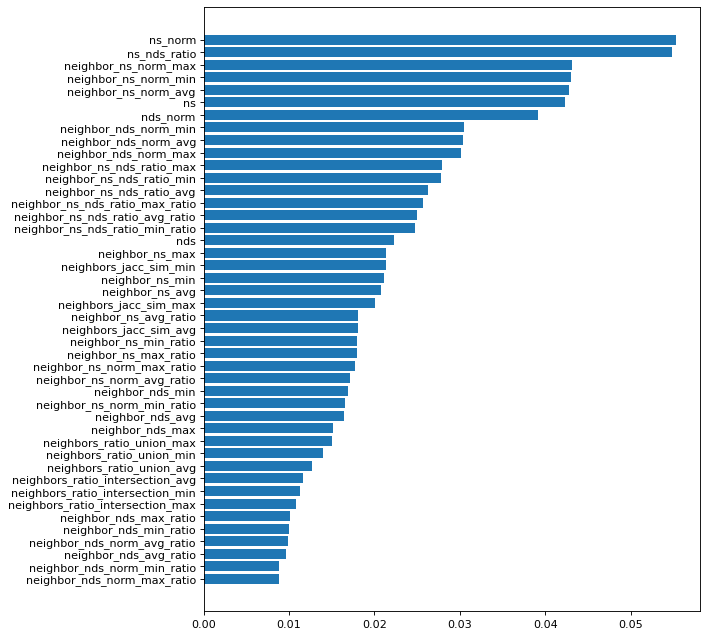

In [75]:
plt.figure(figsize=(8, 10), dpi=80)

plt.barh(np.array(features2use)[rf_clf.feature_importances_.argsort()], 
                                rf_clf.feature_importances_[rf_clf.feature_importances_.argsort()])
                                                                                                   
                                                                                   

- keep working on the machine learning baseline

- maybe include other metrics like complexity of the nodes, etc

- verify if order matters of the features - No as expected, it doesnt

- test this with more complex expansions (like random expansions)

In [41]:
tgt_feat_x, tgt_feat_y = get_props_features_xy(props_dict["dfss2"])

In [42]:
tgt_pred = rf_clf.predict_proba(tgt_feat_x)

In [43]:
statement_probs = []

for s, pr, gt in zip(tgt_prop["steps"], tgt_pred, tgt_feat_y):
    if gt == 1:
        statement_probs.append((s[2], pr[1]))

statement_probs

[('( A C_ B <-> A. x ( x e. A -> x e. B ) )', 0.57),
 ('( A C_ B <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )', 0.33),
 ('( A C_ B <-> A = ( A i^i B ) )', 0.62),
 ('( A = ( A i^i B ) <-> A = { x | ( x e. A /\\ x e. B ) } )', 0.72),
 ('( A i^i B ) = { x | ( x e. A /\\ x e. B ) }', 0.01),
 ('( A = { x | ( x e. A /\\ x e. B ) } <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )',
  0.44),
 ('( A. x ( x e. A -> x e. B ) <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )',
  0.99),
 ('( ( x e. A -> x e. B ) <-> ( x e. A <-> ( x e. A /\\ x e. B ) ) )', 0.86)]

In [33]:
sorted(statement_probs, key=lambda a: a[1])

[('( A i^i B ) = { x | ( x e. A /\\ x e. B ) }', 0.59),
 ('( A C_ B <-> A = ( A i^i B ) )', 0.79),
 ('( A C_ B <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )', 0.81),
 ('( A = { x | ( x e. A /\\ x e. B ) } <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )',
  0.82),
 ('( A C_ B <-> A. x ( x e. A -> x e. B ) )', 0.88),
 ('( ( x e. A -> x e. B ) <-> ( x e. A <-> ( x e. A /\\ x e. B ) ) )', 0.9),
 ('( A = ( A i^i B ) <-> A = { x | ( x e. A /\\ x e. B ) } )', 0.95),
 ('( A. x ( x e. A -> x e. B ) <-> A. x ( x e. A <-> ( x e. A /\\ x e. B ) ) )',
  0.99)]

talvez seja interessante comentar que partir de algo sumarizado para algo mais detalhado eh mais facil apra o estudante do que o contrario do ponto de vista de compreensao ja que para sumarizar para entender melhor o estudante em tese teria ja que ter um dominio do assunto.

preciso verificar porque provavelmente os labels estao vazando por meio da feature number of neighbors because the way we are expnading nodes. Expanding only the first depth will is likely to create a bipartite graph. The proper way to do this is to expand randomly.

Another thing is that the way we are working we cannot detect when we are supposed to have one step in between. This is not a big problem because our proposal here is to summarize (reduce size of presentation) of a proof. But nevertheless, it may also be a good idea to work by hidding steps to help our model generalize better and possible "learn" how to classify such things.